In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

rng = np.random.RandomState(42)

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('water_train.csv')

In [3]:
test = pd.read_csv('water_test.csv')

In [4]:
train.shape

(59400, 40)

In [5]:
test.shape

(14850, 40)

In [6]:
wtarget = pd.read_csv('water_train_target.csv')

In [235]:
train.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [236]:
test.isna().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                    869
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7092
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 37 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null float64
funder                   59400 non-null float64
gps_height               59400 non-null int64
installer                59400 non-null float64
longitude                59400 non-null float64
latitude                 59400 non-null float64
num_private              59400 non-null int64
basin                    59400 non-null float64
region                   59400 non-null float64
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null float64
ward                     59400 non-null float64
population               59400 non-null int64
public_meeting           59400 non-null float64
recorded_by              59400 non-null float64
scheme_management        59400 non-null float64
scheme_name              59400 non-nu

In [ ]:
nume = [key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['int64', 'float64']]

In [9]:
#filling missing numerical values with median
for col in nume:
    if train[col].isna().sum() > 0:
        train[col] = train[col].fillna(train[col].median()[0])

In [10]:
for col in nume:
    if test[col].isna().sum() > 0:
        test[col] = test[col].fillna(test[col].median()[0])

In [11]:
#filling all other missing values with mode
for col in train:
    if train[col].isna().sum() > 0:
        train[col] = train[col].fillna(train[col].mode()[0])

In [12]:
for col in test:
    if test[col].isna().sum() > 0:
        test[col] = test[col].fillna(test[col].mode()[0])

In [263]:
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,region,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,6000.0,1.334615,1.676364,1390,1.287234,34.938093,-9.856322,0,1.356539,1.587646,...,1.572488,1.208706,1.208706,1.376966,1.376966,1.319546,1.319546,1.144495,1.322207,1.236968
1,0.0,1.318182,1.622642,1399,1.692308,34.698766,-2.147466,0,1.091823,0.930422,...,0.973055,1.208706,1.208706,1.142309,1.142309,1.344662,1.344662,1.208208,1.322207,1.236968
2,25.0,1.209386,2.000000,686,1.441176,37.460664,-3.821329,0,1.255145,1.307644,...,1.401113,1.208706,1.208706,1.376966,1.376966,0.807927,0.807927,1.208208,0.838604,1.236968
3,0.0,0.837766,1.228950,263,1.112613,38.486161,-11.155298,0,0.815936,0.678613,...,0.973055,1.208706,1.208706,0.056196,0.056196,1.023476,1.033225,1.144495,0.838604,1.236968
4,0.0,1.008333,1.158838,0,1.155556,31.130847,-1.825359,0,1.091823,1.133293,...,0.973055,1.208706,1.208706,1.250864,1.250864,1.344662,1.344662,1.208208,1.322207,1.236968


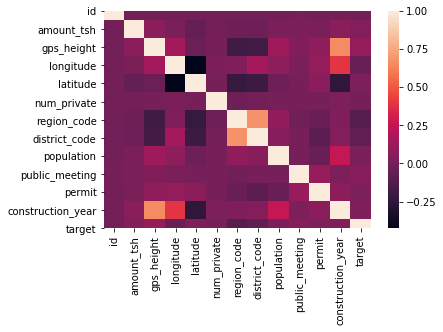

In [23]:
sns.heatmap(train.corr())

In [8]:
cate = [key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['object', 'bool']]

In [168]:
for x in cate:
    print(x)
    print(train[x].nunique())

date_recorded
356
funder
1897
installer
2145
wpt_name
37400
basin
9
subvillage
19287
region
21
lga
125
ward
2092
recorded_by
1
scheme_management
12
scheme_name
2696
extraction_type
18
extraction_type_group
13
extraction_type_class
7
management
12
management_group
5
payment
7
payment_type
7
water_quality
8
quality_group
6
quantity
5
quantity_group
5
source
10
source_type
7
source_class
3
waterpoint_type
7
waterpoint_type_group
6


In [13]:
target = wtarget['status_group']

In [14]:
target

0            functional
1            functional
2            functional
3        non functional
4            functional
              ...      
59395        functional
59396        functional
59397        functional
59398        functional
59399        functional
Name: status_group, Length: 59400, dtype: object

In [15]:
endict = {'functional': 2, 'functional needs repair': 1, 'non functional': 0}

In [16]:
target = target.map(endict)

In [17]:
target

0        2
1        2
2        2
3        0
4        2
        ..
59395    2
59396    2
59397    2
59398    2
59399    2
Name: status_group, Length: 59400, dtype: int64

In [18]:
nume = nume + ['wpt_name', 'subvillage']

In [19]:
nume

['id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'wpt_name',
 'subvillage']

In [20]:
#Target encoding
used_cols = [c for c in train.columns.tolist() if c not in nume]

In [21]:
ce_target_encoder = ce.TargetEncoder(cols = used_cols, smoothing=.3)
ce_target_encoder.fit(train, target)

TargetEncoder(cols=['date_recorded', 'funder', 'installer', 'basin', 'region',
                    'lga', 'ward', 'public_meeting', 'recorded_by',
                    'scheme_management', 'scheme_name', 'permit',
                    'extraction_type', 'extraction_type_group',
                    'extraction_type_class', 'management', 'management_group',
                    'payment', 'payment_type', 'water_quality', 'quality_group',
                    'quantity', 'quantity_group', 'source', 'source_type',
                    'source_class', 'waterpoint_type',
                    'waterpoint_type_group'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=1, return_df=True,
              smoothing=0.3, verbose=0)

In [22]:
train = ce_target_encoder.transform(train)
test = ce_target_encoder.transform(test)

In [254]:

# le = LabelEncoder()
# train['wpt_name'] = le.fit_transform(train['wpt_name'])
# train['subvillage'] = le.fit_transform(train['subvillage'])
# test['wpt_name'] = le.fit_transform(test['wpt_name'])
# test['subvillage'] = le.fit_transform(test['subvillage'])

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null float64
funder                   59400 non-null float64
gps_height               59400 non-null int64
installer                59400 non-null float64
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null float64
num_private              59400 non-null int64
basin                    59400 non-null float64
subvillage               59400 non-null float64
region                   59400 non-null float64
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null float64
ward                     59400 non-null float64
population               59400 non-null int64
public_meeting           59400 non-null

In [23]:
#These columns caused model to over fit so they are dropped
train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)
train = train.drop('wpt_name', axis = 1)
test = test.drop('wpt_name', axis = 1)
train = train.drop('subvillage', axis = 1)
test = test.drop('subvillage', axis = 1)


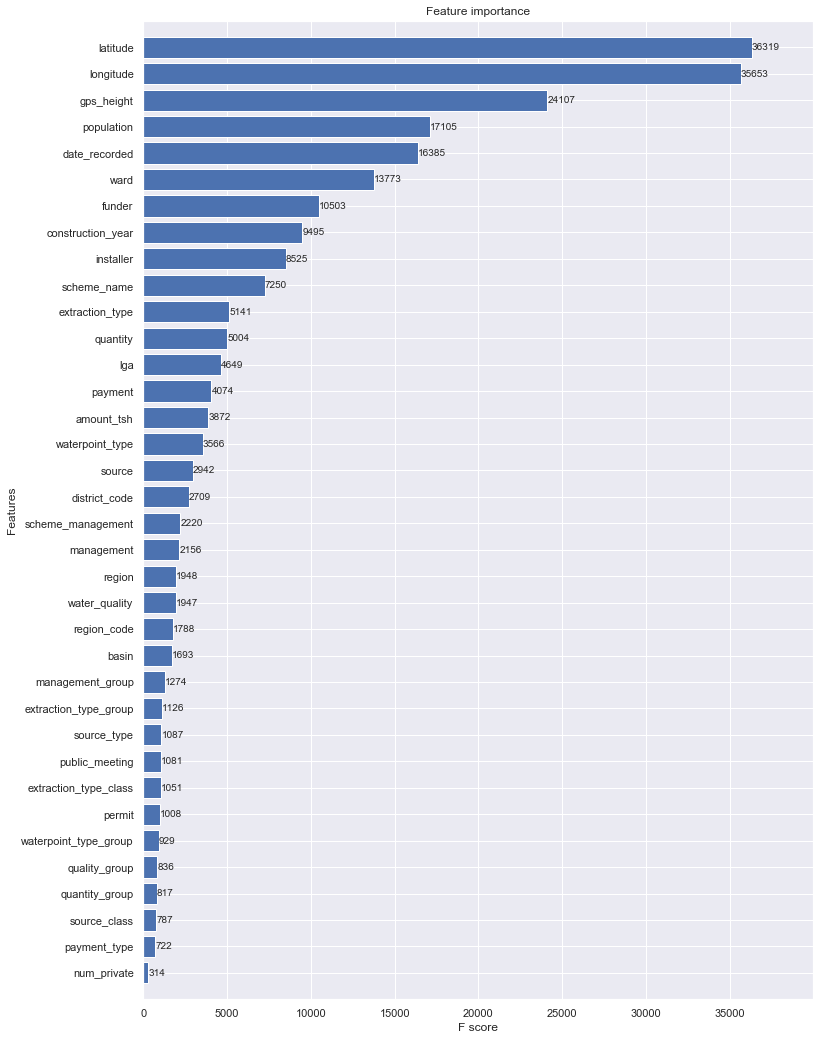

In [47]:
clf = xgb.XGBClassifier(max_depth=11, n_estimators=300, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=.1, n_jobs = -1)
clf.fit(train, target)
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [306]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train, target, 
                                                  stratify=target, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [307]:
predictions = clf.predict(xvalid)
print("accuracy_score",accuracy_score(yvalid, predictions))
# print("auc",roc_auc_score(yvalid, predictions))
# xg = [clf.__class__,accuracy_score(yvalid, predictions),roc_auc_score(yvalid, predictions)]


accuracy_score 0.8710437710437711


In [29]:
scores = cross_val_score(clf, train, target, cv=5, scoring='accuracy') 
print(scores.mean(), "+/-", scores.std())

0.8212289320350159 +/- 0.0024524125608764782


In [302]:
grid_p = {"n_estimators": [100, 200, 300],
          "learning_rate": [.03, .1, .3],
          "max_depth": [8, 10, 12]}

grid_search = GridSearchCV(clf, grid_p, n_jobs=-1, cv=5, scoring='accuracy')
grid_search.fit(train, target)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=7, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=10, objective='multi:softprob',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.1, 0.3],
                         'max_depth': [4, 6, 10],
                         'n_estimators': [50, 100, 200]},


In [303]:
grid_search.best_score_

0.820942760942761

In [304]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}

In [48]:
predictions = clf.predict(test)

In [49]:
pred_dict = {2: 'functional',1: 'functional needs repair', 0:'non functional'}

In [50]:
submit = pd.DataFrame()

In [51]:
sf = pd.read_csv('SubmissionFormat.csv')

In [52]:
submit['id'] = sf['id']
submit['status_group'] = predictions

In [53]:
submit['status_group'] = submit['status_group'].map(pred_dict)

In [54]:
submit.head(30)

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
5,52449,functional
6,24806,functional
7,28965,non functional
8,36301,non functional
9,54122,functional


In [55]:
submit.to_csv('TWWsubmission.csv', index = False)

In [ ]:
#Submission score: .8183
#Current rank 664 / 8268